# Machine Learning in the Industry

Why are we talking about machine learning in a causal inference book, you might ask? Because I think one of the best ways to understand causality is to put it in contrast with Machine Learning. The reason is twofold. First, if you've got to this point in this book, there is a high chance you are already familiar with machine learning and big data. Second, even if you are not, given the current popularity of these topics, you've probably already have some idea on what they are. The only problem is that, with all the hype around these topics, I might have to bring you back to earth and explain what machine learning really does in very practical terms.

As I've said in the beginning of the book, **machine learning is a way to make fast, automatic and good predictions**. That's not the entire picture, but we could say that it covers 90% of it. This is the field of supervised machine learning, where most of the cool advancements, like computer vision, self-driving cars, language translation and diagnostics, have been made. Notice how at first these might not seem like prediction tasks. How is language translation a prediction? And that's the beauty of machine learning. We can solve more problems with prediction than what is initially apparent. In the case of language translation, you can frame it as a prediction problem where you present a machine with one sentence and it has to predict the same sentence in another language. Here, I'm not using the word prediction in a forecasting or anticipating the future way. Prediction is simply learning how to map from one defined input to an equally defined output. 

![img](./data/img/industry-ml/translation.png)

If you can frame a problem as this mapping from an input to an output, then machine learning might be a good candidate to solve it. As for self driving cars, you can think of it as not one, but multiple complex prediction problems: predicting the correct angle of the wheel from infrared sensors in the front of the car, prediction the pressure in the brakes from to images from cameras around the car, prediction pressure in the accelerator from gps data. Solving those (and a tone more) of problems is what makes a self driving car.

OK… You now understand how prediction can be more powerful than we first though. But self-driving cars and language translation are cool and all, but they are quite distant, unless you work at a major tech company like Google or Uber. So, to make this more relatable, let's talk in terms of problems almost every company has: customer acquisition. 

From the customer acquisition perspective, what you often have to do is figuring out who are the profitable customers. In this problem, each customer has a cost of acquisition (maybe marketing costs, onboarding costs, shipping costs...) and will hopefully generate a positive cashflow for the company. For example, let's say you are an internet provider or a gas company. Your typical customer might have a cash flow that looks something like this.

![img](./data/img/industry-ml/cashflow-1.png)

Each bar represents a monetary event in the life of your relationship with the customer. For example, to get a customer, right off the bet, you need to invest in marketing. Then, after someone decides to do business with you, you might incur in some sort of onboarding cost (where you have to explain to your customer how to use your product) or installation costs. Only then, the customer starts to generate monthly revenues. At some point, the customer might need some assistance and you will have maintenance costs. Finally, if the customer decides to end the contract, you might have some final costs for that too. 

To see if this is a profitable customer, we can rearrange the bar in what is called a cascade plot. Hopefully, the sum of the cash events end up way above the zero line.

![img](./data/img/industry-ml/cascade-1.png)

In contrast, it could very well be that the customer will generate much more costs than revenues. If he or she uses very little of your product and has high maintenance demands, when we pile up the cash events, they could end up below the line.

![img](./data/img/industry-ml/cascade-2.png)

Of course, this cash flow could be simpler, with only one or two events in the case of a single transaction, or much more complicated, depending on the type of business. You can do stuff like time discounts with an interest rate and get all crazy about it, but I think the point here is made.

But what can you do about this? Well, if you have many examples of profitable and non profitable customers, you can train a machine learning model to identify them. That way, you can focus your marketing strategies only on the profitable customers. Or, if your contract permits, you can end relations with a customer before he or she generates more costs. Essentially, what you are doing here, is framing the problem as a prediction so that you can solve it with machine learning: you want to predict or identify profitable and unprofitable customers so that you only engage with the profitable ones.


In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

For instance, suppose you have 30 days of transactional data on 10000 customers. You also have the cost of acquisition `cacq`. This could be the bid you place for them if you are doing online marketing, it could be the cost of shipping or any training you have to do with your customer so they can use your product. Also, for the sake of simplicity (this is a crash course, not a semester on customer valuation), let's pretend you have total control of the customer that you do business with. In other words, you have full control if a customer can or can't buy from you. If that's the case, your task now becomes identifying who will be profitable beforehand, so you can choose to engage only with them.

In [2]:
transactions = pd.read_csv("data/customer_transactions.csv")
print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,6,0,73,10,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
1,1,-58,0,0,0,15,0,3,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,3,2,0,9,0,0,0,...,0,0,40,0,0,0,0,0,0,0
4,4,-42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What we need to do now is distinguish the good from the bad customers according to this transactional data. For the sake of simplicity, I'll just sum up all transactions and the CACQ. Keep in mind that this throws under the rug a lot of nuances, like distinguishing customers that churned from those that are in a break between one purchase and the next, but for our crash course it will do. 

I'll then join this sum, which I call `net_value`, with customer specific features. Since my goals is to figure out which customer will be profitable **before** deciding to engage in them, you can only use data prior to the acquisition period. In our case, these features are age, region and income, available at another csv file.

In [3]:
profitable = (transactions[["customer_id"]]
              .assign(net_value = transactions
                      .drop(columns="customer_id")
                      .sum(axis=1)))

customer_features = (pd.read_csv("data/customer_features.csv")
                     .merge(profitable, on="customer_id"))

customer_features.head()

,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


Now our task is becoming less abstract. We wish to identify the profitable customers (`net_value > 0`) from the non profitable ones. Let's try different things and see which one works better. 

In order to do that, we need to simulate how this data will be used to make decisions in the real world. The process goes like this:

1. We have data on existing customers, from those we know which ones are profitables and which are not. Let's call our internal data the training set.
2. We will use the internal data to learn a rule that tells us which customer is profitable (hence training).
3. We will apply the rule to customers that we've never seen before and, hence, don't know if they are profitable or not. 

Here, I'll use two concepts. A **prediction** in a number that estimates or predicts something. For example, we can try to predict the profitability of a customer and the prediction would be something like 16 reais, meaning that we predict this customer to generate 16 reais in revenue. The point here is that prediction is a simple number. The second concept is that of a **policy**. A policy is an automatic decision rule. While a prediction is a number, a prediction is a decision. For example, we can have a policy that engages with customers with income greater than 1000 and doesn't engage otherwise. We usually build policies on top of prediction: engage with all customers that have profitability predictions above 10 and don't engage otherwise. Machine learning will usually take care of the first, that is, of prediction. But notice that prediction alone is useless. We need to attach some decision, or policy to it.

We can do very simple policies and models or very complicated ones. To know which one is better, we need to simulate this real life scenario with the data that we have. What we will do is pretend that we don't have a part or our samples, say 3000. We can then use the other 7000 to learn a rule and the 3000 to test it. In machine learning, this is called train-test split, or cross validation.

In [4]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 5), (3000, 5))

We are all good. What now? Before we go machine learning crazy, let's try the simple stuff first. The 80% gain with 20% effort stuff. They often work wonders and, surprising, most data scientists forget about them. 

So, what is the simplest thing we can do? Naturally, just engage with all the customers! Instead of figuring out which ones are profitable, let's just do business with everyone and hope the profitable customers more than compensate for the non profitable ones. 

To check if this is a good idea, we can see the mean net value of the customers. If that is positive, it means that, on average, we will make money on our customers. Sure, there will be profitable and non profitable ones, but on average, if we have enough customers, we will make money. On the other hand, if this value is negative, it means that we will lose money if we engage with all the customers.

In [5]:
train["net_value"].mean()

-29.169428571428572

So that's a bummer... If we engage with everyone, we would lose about 30 reais for each customer we do business with. So our first, very simple thing didn't work and we better find something better if we don't want to go out of business.

Just a quick side note here, you will find situations like this in real life, but keep in mind that this is a pedagogical example. For the vast majority of cases, you will find that very simple policies, like doing business with everyone, work in practice.

Moving forward to the next simplest thing we can think of is taking our features and seeing if they alone distinguish the good from the bad customers. Take `income`, for instance, it's intuitive that richer customers should be more profitable, right? What if we do business only with the top richest customers? Will that be a good idea?

To figure this out we can partition our data into ten income quantiles (a quantile has the propriety of dividing the data into partitions of equal size, that's why I like them). Then, for each income quantile, we let's compute the average net value. The hope here is that, although the average net value in negative, \\(E[NetValue]<0\\), we hope to find some subpopulation defined by income where the net value is positive, \\(E[NetValue|Income=x]<0\\), probably, higher income levels.

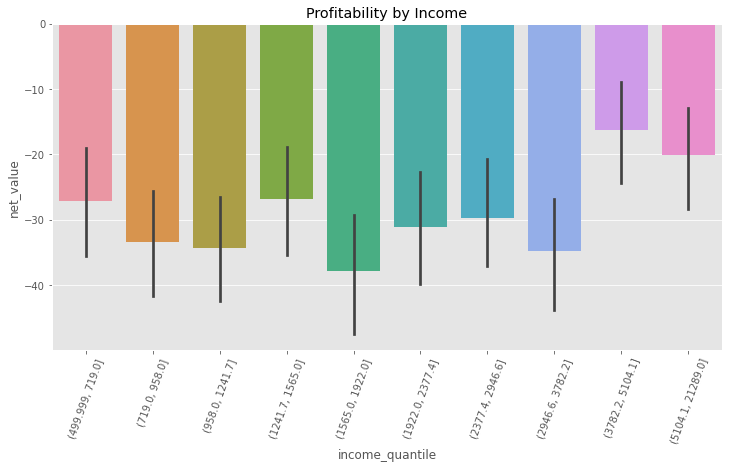

In [6]:
plt.figure(figsize=(12,6))
np.random.seed(123) ## seed because the CIs from seaborn uses boostrap

# pd.qcut create quantiles of a column
sns.barplot(data=train.assign(income_quantile=pd.qcut(train["income"], q=10)), 
            x="income_quantile", y="net_value")
plt.title("Profitability by Income")
plt.xticks(rotation=70);

And, sadly, nope. Yet again, all levels of income have negative average net value. Although it is true that richer customers are "less bad" than non rich customers for our business, they still generate, on average, negative net value. So income didn't help us much here, but what about the other variables, like region? If most of our costs come, say, from having to serve customers in far away places, we should expect that the region distinguishes the profitable from the unprofitable.

Since region is already a categorical variable, we don't need to use quantiles here. Let's just see the average net value per region.

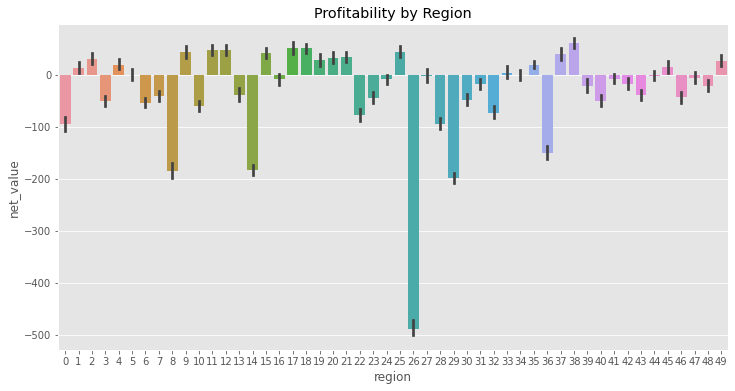

In [7]:
plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value")
plt.title("Profitability by Region");

Bingo! We can see clearly that some regions are profitable, like regions 2, 17, 39, and some are not profitable, like region 0, 9, 29 and the specially bad region 26. This is looking super promissing! We can take this and tranform into a policy: only do business with the regions that showed to be profitable *accoring to the data that we have here*. 

To construct this policy, we will be conservative and take only the regions where the lower end of the confidence interval is above zero. A region like 44, although sligly positve, will be left out according to this policy.

The following code extracts the lowest y value for each point in the plot above. The `enumerate` thing just zips each point with an index (0 to 49, since there are 49 points). We can do this only because the points are ordered from region 0 to 49. Then, the second dictionary generator filters only those where the lower end of the confidence interval is above zero. The result is the regions we will do business with according to our policy.

In [8]:
# extract the lower bound of the 95% CI from the plot above
regions_to_net = {region: line.get_ydata().min()
                  for region, line in enumerate(region_plot.lines)}

# filters regions where the net value is > 0.
regions_to_invest = {region: net 
                     for region, net in regions_to_net.items()
                     if net > 0}

regions_to_invest

{1: 3.153885135135136,
 2: 21.25300751879699,
 4: 10.643437500000001,
 9: 31.69293893129771,
 11: 38.24736842105263,
 12: 37.41948051948052,
 15: 33.11847014925374,
 17: 39.74547101449275,
 18: 41.631028368794325,
 19: 15.991666666666667,
 20: 22.184742647058826,
 21: 24.609166666666667,
 25: 34.07966666666666,
 35: 12.195987654320987,
 37: 28.841785714285713,
 38: 50.52307692307692,
 45: 3.707462686567164,
 49: 16.766940789473683}

`regions_to_invest` has all the regions we will engage with, according to this policy. Lets now see how this policy would have performed in our test set, the one we pretend not to have. This is a key step in evaluating our policy, because it could very well be that, simply by chance, a region in our training set is appearing to be profitable. If that is only due to randomness, it will be unlikely that we find that same pattern in the test set.

To do so, we will filter only the customers in the regions defined as profitable using our training set. Then, we will plot the distribution of net income for those customers and also show the average net income of our policy.

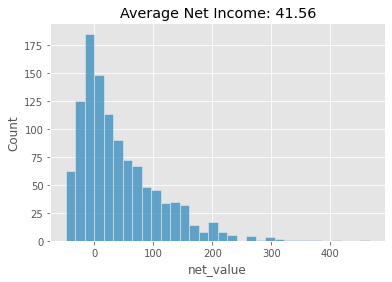

In [9]:
region_policy = (test[test["region"]
                      # filter regions in regions_to_invest
                      .isin(regions_to_invest.keys())]) 

sns.histplot(data=region_policy, x="net_value")
plt.title("Average Net Income: %.2f" % region_policy["net_value"].mean());

Not bad! If we use this very simple rule of doing business with only those regions, we can expect to gain about 40 reais per customer. Sure, there will be some customer that will make us lose money (the ones below zero in our histogram), but the profitable ones will more than compensate for that.

Now that you've figured this out, pat yourself in the back! It's already a super useful policy. Your boss will be super happy because your company can make money instead of losing it on customers. What an achievement! Let this be a lesson to never  underestimate the value of simple policies.

But, if you are still willing to do even better, we can now use the power of machine learning. Keep in mind that this will add tones of complexity to the whole thing and usually, only marginal gains. But, depending on the circumstances, marginal gains can be translated into huge piles of money and that's why machine learning is so valuable these days.

Here, I'll use a Gradient Boosting model. It's a fairly complicated model to explain, but it's very simple to use. For our purpose here, we don't need to get into the details of how it works. Instead, you just need to understand what machine learning does in a broad sense. You can think of machine learning models as things that can approximate almost any function. Another way of saying this is that they can be made so powerful as to perfectly fit the data in the training set. In the image below, you can see examples of a simple model, an intermediate model and a complex model. Notice how the complex model has a perfect fit of the data.

![img](./data/img/industry-ml/model-fit.png)

However, if you give too much power to your model, it will use it not only to learn the patterns in your data, but also the random variations and noise. Then, when you apply this model to another dataset, it won't generalize well. In the image below, you can see how the same models perform in a new, unseen data. Notice how the complex model doesn't do a very good job fitting this new data.

![img](./data/img/industry-ml/test.png)

Finding the right complexity of a model is an art in machine learning and it is the reason we divide our dataset into a partition used for estimation (training set) and a partition used for evaluation (test set or holdout set).

But enough of this ML intro. The fundamental question we need to ask is, how does all of this can be used to improve upon our simple region policy to identify and engage with profitable customers? I think there are two main improvements here that we can make. First, you will have to agree that going through all the features looking for one that distinguishes customers is a cumbersome process. Here, we had only 3 (age, income and region), so it wasn't that bad, but imagine if we had more than 100. Also, you have to be careful with issue of [multiple testing](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) and false positive rates. The second reason is that it is probably the case that features other than region also have some information on customer profitability. Sure, when we looked at income alone it didn't give us much, but what about income on those regions that are just barely unprofitable? Maybe, on those regions, if we focus only on richer customers, we could still get some profit. Coming up with these more complicated policies that involve interacting more than one feature can be super complex. The combinations we have to look at grows exponentially with the number of features and it is simply not a practical thing to do. Istead, what we can do is throw all those features into a machine learning model and have it learn those interactions for us. This is precisely what we will do now.

The goal of this model will be to predict `net_value` using `region`, `income`, `age`. To help it, we will take the region feature, which is categorical, and encode it with the lower end of the confidence interval of net income for that region. Remember that we have those stored in the `regions_to_net` dictionary. With this, all we have to do is call the method `.replace()` and pass this dictionary as the argument. I'll create a function for this, because we will do this replacement multiple times. 

In [10]:
def encode(df): 
    return df.replace({"region": regions_to_net})

Next, our model will be imported from sklearn. They all have a pretty standard usage. First, you instantiate the model passing in the parameters. For this model, we will set the number of estimators to 400, the max depth to 4 and so on. Again, you don't need to know the details of what these parameters do. Just keep in mind that this is a very good prediction model. Then, to train our model, we will call the `.fit()` method, passing the features `X` and the variable we want to predict - or target variable -, `net_value`. 

In [11]:
model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(123)

reg = ensemble.GradientBoostingRegressor(**model_params)

# fit model on the training set
encoded_train = train[features].pipe(encode)
reg.fit(encoded_train, train[target])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The model is trained. Now, we need to check if it is any good. To do this, we can look at the predictive performance of this model **on the test set**. Since this is a regression model (it predictis a continuous number), we can use the \\(R^2\\) to evaluate it. It tells us how much of the variance in `net_income` is explained by our model.

In [12]:
print("Train R2: ", r2_score(y_true=train[target],
                             y_pred=reg.predict(encoded_train[features])))
print("Test R2: ", r2_score(y_true=test[target],
                            y_pred=reg.predict(test[features].pipe(encode))))

Train R2:  0.7107517170875854
Test R2:  0.6938320480386047


In this case, the model explains about 71% of the `net_income` variance in the training set but only about 69% of the net_income variance in the test set. This is expected. Since the model had access to the training set, it's performance there will often be overestimated on that data. 

Next, in order to make our policy, we will store the test set predictions in a `prediction` column.

In [13]:
model_policy = (test
                .assign(prediction=reg.predict(test[features].pipe(encode))))

model_policy.head()

,customer_id,region,income,age,net_value,prediction
5952,5952,19,1983,23,21,47.607404
1783,1783,31,914,31,-46,-36.168838
4811,4811,33,1349,25,-19,22.575077
145,145,20,1840,26,55,47.941833
7146,7146,19,3032,34,-17,4.608359


And just like we did with the regions, we can show the average net value by predictions of our model. But since the model is continuous and not categorical, we need to make it discrete first. One way of doing so is using pandas `pd.qcut`, which partitions the data into quantiles using the model prediction. Let's use 50 quantiles because 50 is the number of regions that we had. And just as a convention, I tend to call this model quantile **model bands**, because it gives the intuition that this group has model predictions within a band, say, from -10 to 200. 

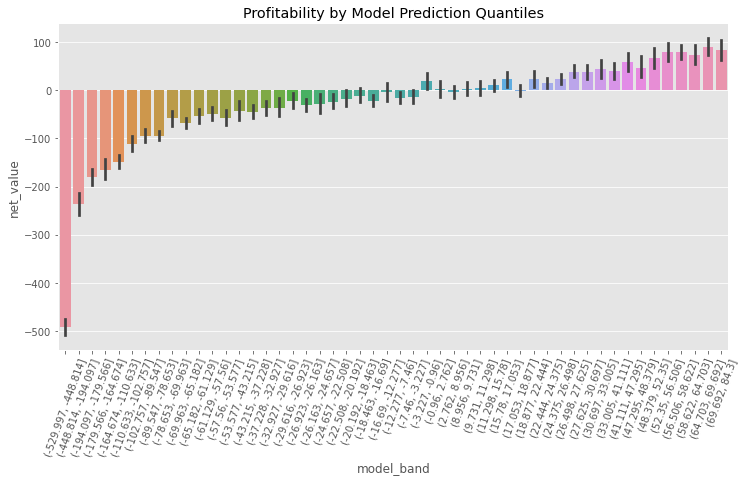

In [14]:
plt.figure(figsize=(12,6))

n_bands = 50
bands = [f"band_{b}" for b in range(1,n_bands+1)]

np.random.seed(123)
model_plot = sns.barplot(data=model_policy
                         .assign(model_band = pd.qcut(model_policy["prediction"],
                                                      q=n_bands)),
                         x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70);

Here, notice how there are model bands where the net value is super negative, while there are also bands where it is very positive. Also, there are bands where we don't know exactly if the net value is negative or positive. Finally, notice how they have an upward trend, from left to right. Since we are predicting net income, it is expected that the prediction is proportional to it, if the model is any good.

Now, to compare this policy using a machine learning model with the one using only the regions, we can also show the histogram of net gains, along with the total net value in the test set.

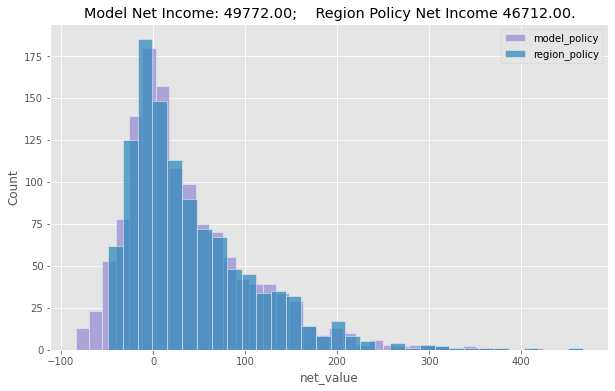

In [18]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")

region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f;    Region Policy Net Income %.2f." % 
          (model_plot_df["net_value"].sum(), region_plot_df["net_value"].sum()))
plt.legend();

As we can see, the model generates a better policy than the regions, but not by much. While the model policy would have made us about 49.5k reais on the test set, the region policy would have made us only 46.5k. It's just slightly better, but if you have tons and tons of customers, this might already justify using a model instead of a simple one feature policy.

There are tones of other ways to visualize this model comparison, but I'll show just one more that I like. We plot model quantiles on the x axis and the business metric, net income, in the y axis. If the model is any good, low quantiles of the model will also have low net income and high quantiles will have high net income. The better the model, the more pronounced the slope of the line will be.

One detail with this method is that region is a categorical variable which is not ordered according to net value. You can't say that regions 1,2,3,4 have low net income and regions 47, 48, 49 have high net income. Those are just categories that have no business meaning. So, in order for region to be able to order net income, we have to do some pre-processing. Namely, we will replace the region index by the net income value predicted by its policy, that is, the lower bound of the CI that I've stored in the `regions_to_net` dictionary. This new encoded variable will have a business interpretation in the sense that the higher it is, the more net income we expect to see. This ordering will make it comparable to the machine learning policy.

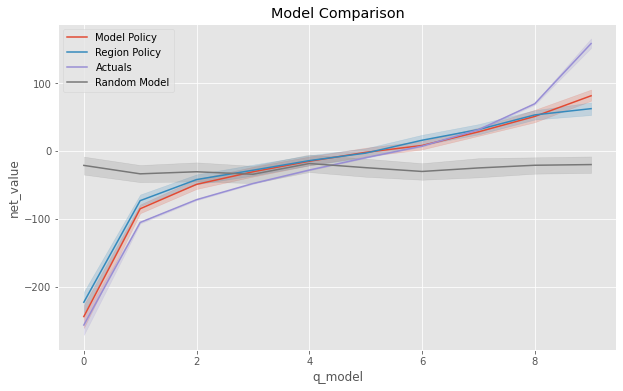

In [16]:
plt.figure(figsize=(10,6))
bins=10

def plot_model_line(df:pd.DataFrame, predictions: pd.Series, bins: int, name: str):
    sns.lineplot(data=df.assign(q_model = pd.qcut(predictions, q=bins, labels=range(bins))),
                 x="q_model",
                 y="net_value",
                 label=name)
    
plot_model_line(model_policy, model_policy["prediction"], bins, "Model Policy")
plot_model_line(model_policy, model_policy["region"].replace(regions_to_net), bins, "Region Policy")
plot_model_line(model_policy, model_policy["net_value"], bins, "Actuals")
plot_model_line(model_policy, np.random.uniform(size=model_policy.shape[0]), bins, "Random Model")

plt.title("Model Comparison");

As you can see, the model policy line starts lower than the region policy line and ends higher than that line. This shows that the model is better at ordering the `net_income` variable. I've also shown in the plot above what a random model looks like. This model is just outputting random variables, so we should expect it to have no slope at all as it doesn't help to distinguish good from bad customers. Along with that, I've added the true net value (purple line). The closer the model lines are to it, the better the model. We can see that both region and model lines are close to it, but the model one is slightly closer.